In [11]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'svg'
from cvxpy import *

import scipy
import scipy.spatial

In [12]:
# useful functions

# get all pairs of vertices in a triangle
def tri_pairs(s):
    a = [[s[0],s[1]],[s[1],s[2]],[s[2],s[0]]]
    return {tuple(sorted(x)) for x in a}

# get all pairs of vertices in a triagularization
def all_pairs(simplices):
    pairs = set()
    for s in tri.simplices:
        pairs.update(tri_pairs(s))
    pair_list = list(pairs)
    pair_list.sort()
    return pair_list

# get distance between two points
def dist(a,b):
    return np.sqrt((a[0]-b[0])*(a[0]-b[0]) + (a[1]-b[1])*(a[1]-b[1]))

# get distance between desired pairs of vertices
def dist_array(X,pairs):
    dist_list = [dist(X[i,:],X[j,:]) for (i,j) in pairs]
    return np.array(dist_list)

def get_pair_dist(X,simplices):
    p = all_pairs(simplices)
    d = dist_array(X,p)
    return zip(p,d)

# generate grid of points
def mesh_points(points_per_dim):
    n_points = points_per_dim*points_per_dim
    xm = np.linspace(0,1,points_per_dim)
    ym = np.linspace(0,1,points_per_dim)
    xv,yv = np.meshgrid(xm,ym)
    Xm = np.vstack([xv.reshape(n_points),yv.reshape(n_points)]).T
    return Xm

In [13]:
# adjustment function
def adjust(X_data,pairs,d_true,fixed_points):
    n_pairs = len(pairs)
    d_data = dist_array(X_data,pairs)
    d_diff = 0.5*(d_true**2 - d_data**2)
    X_var = Variable(n_points,2)
    
    # construct objective function
    eqn = list()
    for i, p in enumerate(pairs):
        pi = p[0]
        pj = p[1]
        eqn.append((X_data[pi,0]-X_data[pj,0])*X_var[pi,0]
                   -(X_data[pi,0]-X_data[pj,0])*X_var[pj,0]
                   +(X_data[pi,1]-X_data[pj,1])*X_var[pi,1]
                   -(X_data[pi,1]-X_data[pj,1])*X_var[pj,1]
                   -d_diff[i])
    objective = Minimize(sum_squares(vstack(*eqn)))

    # handle constraints (fixed points)
    constraints = list()
    for i in fixed_points:
        constraints.append(X_var[i,0] == 0.0)
        constraints.append(X_var[i,1] == 0.0)
    
    # solve the problem
    prob = Problem(objective,constraints)
    prob.solve()

    # adjust the data
    X_adj = X_data + np.array(X_var.value)
    

    return X_adj

In [14]:
# objective value
def objective_value(X_data,pairs,d_true):
    n_pairs = len(pairs)
    d_data = dist_array(X_data,pairs)
    d_diff = 0.5*(d_true**2 - d_data**2)
    return 0.5*np.linalg.norm(d_diff)

In [15]:
# generate data
#n_points = 3
#X_true = np.array([[0,0],[1,0],[0,1]],dtype=np.float64)
#X_data = np.array([[0,0],[1,0],[0.1,1]],dtype=np.float64)

n_points = 5*5
np.random.seed(1)
X_true = mesh_points(5)+0.05*np.random.randn(n_points,2)
X_data = X_true + 0.1*np.random.randn(n_points,2)

fixed_points = (0,24)
# revert the fixed points
for i in fixed_points:
    X_data[i,:] = X_true[i,:]

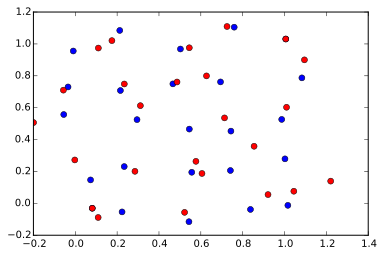

In [16]:
# plot
plt.plot(X_true[:,0],X_true[:,1],'o')
plt.plot(X_data[:,0],X_data[:,1],'ro')
#plt.xlim(-.1,1.1)
#plt.ylim(-.1,1.1)

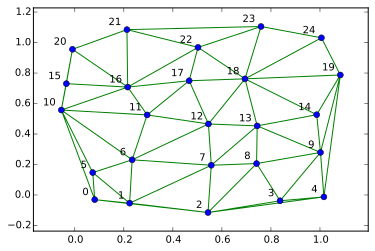

In [17]:
# generate a plot the triangularization
tri = scipy.spatial.Delaunay(X_true)
scipy.spatial.delaunay_plot_2d(tri)
for j, p in enumerate(X_true):
     plt.text(p[0]-0.03, p[1]+0.03, j, ha='right')

plt.savefig('fig/tri-1.pdf')

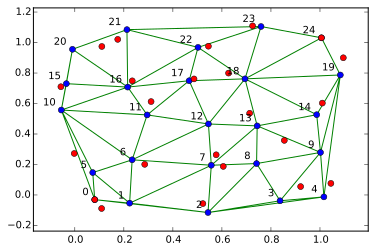

In [18]:
# generate a plot the triangularization
tri = scipy.spatial.Delaunay(X_true)
scipy.spatial.delaunay_plot_2d(tri)
for j, p in enumerate(X_true):
     plt.text(p[0]-0.03, p[1]+0.03, j, ha='right')

plt.plot(X_data[:,0],X_data[:,1],'ro')
plt.savefig('fig/tri-2.pdf')

In [19]:
pairs = all_pairs(tri.simplices)
d_true = dist_array(X_true,pairs)


X_adj = adjust(X_data,pairs,d_true,fixed_points)

print('obj(X_data) = {}'.format(objective_value(X_data,pairs,d_true)))
print('obj(X_adj) = {}'.format(objective_value(X_adj,pairs,d_true)))

obj(X_data) = 0.188112150308
obj(X_adj) = 0.0564810656952


obj(X_data) = 0.188112150308
obj(X_adj1) = 0.0564810656952
obj(X_adj2) = 0.00917914789852
obj(X_adj3) = 0.000585643034354
obj(X_adj4) = 2.21041234648e-06
obj(X_adj5) = 2.43203285851e-11
obj(X_adj6) = 2.8549042626e-15
obj(X_adj7) = 2.84245610885e-15


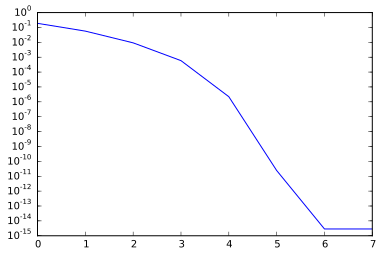

In [21]:
X_adj1 = adjust(X_data,pairs,d_true,fixed_points)
X_adj2 = adjust(X_adj1,pairs,d_true,fixed_points)
X_adj3 = adjust(X_adj2,pairs,d_true,fixed_points)
X_adj4 = adjust(X_adj3,pairs,d_true,fixed_points)
X_adj5 = adjust(X_adj4,pairs,d_true,fixed_points)
X_adj6 = adjust(X_adj5,pairs,d_true,fixed_points)
X_adj7 = adjust(X_adj6,pairs,d_true,fixed_points)

err = list()
err.append(objective_value(X_data,pairs,d_true))
err.append(objective_value(X_adj1,pairs,d_true))
err.append(objective_value(X_adj2,pairs,d_true))
err.append(objective_value(X_adj3,pairs,d_true))
err.append(objective_value(X_adj4,pairs,d_true))
err.append(objective_value(X_adj5,pairs,d_true))
err.append(objective_value(X_adj6,pairs,d_true))
err.append(objective_value(X_adj7,pairs,d_true))

print('obj(X_data) = {}'.format(objective_value(X_data,pairs,d_true)))
print('obj(X_adj1) = {}'.format(objective_value(X_adj1,pairs,d_true)))
print('obj(X_adj2) = {}'.format(objective_value(X_adj2,pairs,d_true)))
print('obj(X_adj3) = {}'.format(objective_value(X_adj3,pairs,d_true)))
print('obj(X_adj4) = {}'.format(objective_value(X_adj4,pairs,d_true)))
print('obj(X_adj5) = {}'.format(objective_value(X_adj5,pairs,d_true)))
print('obj(X_adj6) = {}'.format(objective_value(X_adj6,pairs,d_true)))
print('obj(X_adj7) = {}'.format(objective_value(X_adj7,pairs,d_true)))



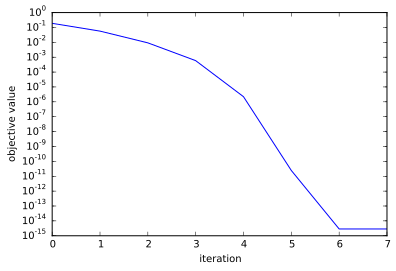

In [23]:
# plot error
plt.figure()
plt.semilogy(err)
plt.xlabel('iteration')
plt.ylabel('objective value')
plt.savefig('fig/tri-3.pdf')

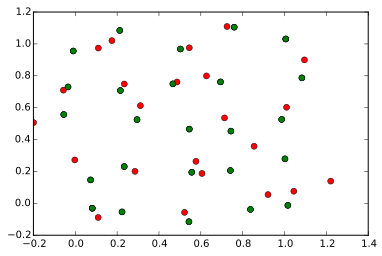

In [137]:
# plot
plt.plot(X_true[:,0],X_true[:,1],'o')
plt.plot(X_data[:,0],X_data[:,1],'ro')
plt.plot(X_adj7[:,0],X_adj7[:,1],'go')
#plt.xlim(-.1,1.1)
#plt.ylim(-.1,1.1)

In [123]:
X_true - X_adj5

array([[ 0.        ,  0.        ],
       [ 0.        ,  0.        ],
       [ 0.02997954,  0.40833066],
       [ 0.88247332,  0.16317759],
       [ 1.2777265 , -0.18452361],
       [-0.16519826,  0.71803254],
       [-0.07312115,  0.15801055],
       [ 0.58363909,  0.64741749],
       [ 0.84698223,  0.9957425 ],
       [ 1.45313966,  0.55470646],
       [-1.25449266,  0.78886882],
       [-0.15622376,  0.8811343 ],
       [ 0.45969466,  0.63314967],
       [ 0.5299256 ,  1.01371581],
       [ 0.98078957,  1.27955447],
       [-0.87697562,  0.91704621],
       [-0.6147357 ,  1.25763291],
       [ 0.16454101,  1.36830654],
       [ 0.12450486,  1.15622723],
       [ 0.76404286,  1.82885303],
       [-0.40730524,  1.05487152],
       [-0.53795366,  1.10222113],
       [ 0.19355359,  1.12775132],
       [ 0.41323189,  1.87369237],
       [ 0.27008234,  2.03380254]])